In [106]:
from transpile_benchy.interface import QASMBench, RedQueen

qasm_bench_s = QASMBench(size="small")
qasm_bench_m = QASMBench(size="medium")
# redqueen = RedQueen()

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(5, 6)
# coupling_map = CouplingMap.from_grid(2,2)

from virtual_swap.pass_managers import SabreCNSV2, QiskitLevel3, SabreQiskit

In [107]:
# # 5Q backend = provider.backend.ibmq_quito
# from qiskit.providers.fake_provider import FakeQuitoV2
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# # # GHZ/BV, QV, EfficientSU2-linear, EfficientSU2-full, Two-local linear, QFT,
# # from qiskit import QuantumCircuit
# # def ghz():
# #     num_qubits = 5
# #     qc = QuantumCircuit(num_qubits, num_qubits, name="ghz")

# #     # Create a GHZ state
# #     qc.h(0)
# #     for i in range(num_qubits - 1):
# #         qc.cx(i, i + 1)
# #     # Insert a barrier before measurement
# #     qc.barrier()
# #     # Measure all of the qubits in the standard basis
# #     for i in range(num_qubits):
# #         qc.measure(i, i)
# #     return qc

# # from qiskit.circuit.library import QuantumVolume
# # def qv():
# #     return QuantumVolume(5, seed=0)

In [108]:
# # 5Q backend = provider.backend.ibmq_quito
# # 20Q backend = provider.backend.ibmq_mumbai
# from typing import Callable, List
# from transpile_benchy.interface import QiskitInterface
# class QiskitFunctions(QiskitInterface):
#     def _get_qiskit_functions(self) -> List[Callable]:
#         return [ghz, qv]

# qiskit_functions = QiskitFunctions()

In [109]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        SabreCNSV2(coupling_map, logger=transpile_benchy_logger),
        # SabreQiskit(coupling_map),
        QiskitLevel3(coupling_map),
    ],
    submodules=[qasm_bench_s, qasm_bench_m],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
    num_runs=10,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QASMBench:   0%|          | 0/38 [00:00<?, ?it/s]INFO:transpile_benchy:Accepted CNS subs: 2
INFO:transpile_benchy:Accepted CNS subs: 3
INFO:transpile_benchy:Accepted CNS subs: 2
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 2
INFO:transpile_benchy:Accepted CNS subs: 3
INFO:transpile_benchy:Accepted CNS subs: 3
INFO:transpile_benchy:Accepted CNS subs: 4
INFO:transpile_benchy:Accepted CNS subs: 3
INFO:transpile_benchy:Accepted CNS subs: 2
Running circuits for QASMBench:   3%|▎         | 1/38 [00:02<01:38,  2.66s/it]INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy

"It was not possible to use the basis ['u', 'cx', 'iswap', 'swap']"


INFO:transpile_benchy:Accepted CNS subs: 2


"It was not possible to use the basis ['u', 'cx', 'iswap', 'swap']"


INFO:transpile_benchy:Accepted CNS subs: 2


"It was not possible to use the basis ['u', 'cx', 'iswap', 'swap']"


INFO:transpile_benchy:Accepted CNS subs: 3
INFO:transpile_benchy:Accepted CNS subs: 3


"It was not possible to use the basis ['u', 'cx', 'iswap', 'swap']"


INFO:transpile_benchy:Accepted CNS subs: 3


"It was not possible to use the basis ['u', 'cx', 'iswap', 'swap']"


INFO:transpile_benchy:Accepted CNS subs: 2
Running circuits for QASMBench:  18%|█▊        | 7/38 [00:20<02:12,  4.28s/it]INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
Running circuits for QASMBench:  21%|██        | 8/38 [00:21<01:36,  3.23s/it]INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accepted CNS subs: 0
INFO:transpile_benchy:Accep

array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


INFO:transpile_benchy:Accepted CNS subs: 0


array must not contain infs or NaNs


Running circuits for QASMBench:  39%|███▉      | 15/38 [00:50<01:16,  3.34s/it]


ValueError: array must not contain infs or NaNs

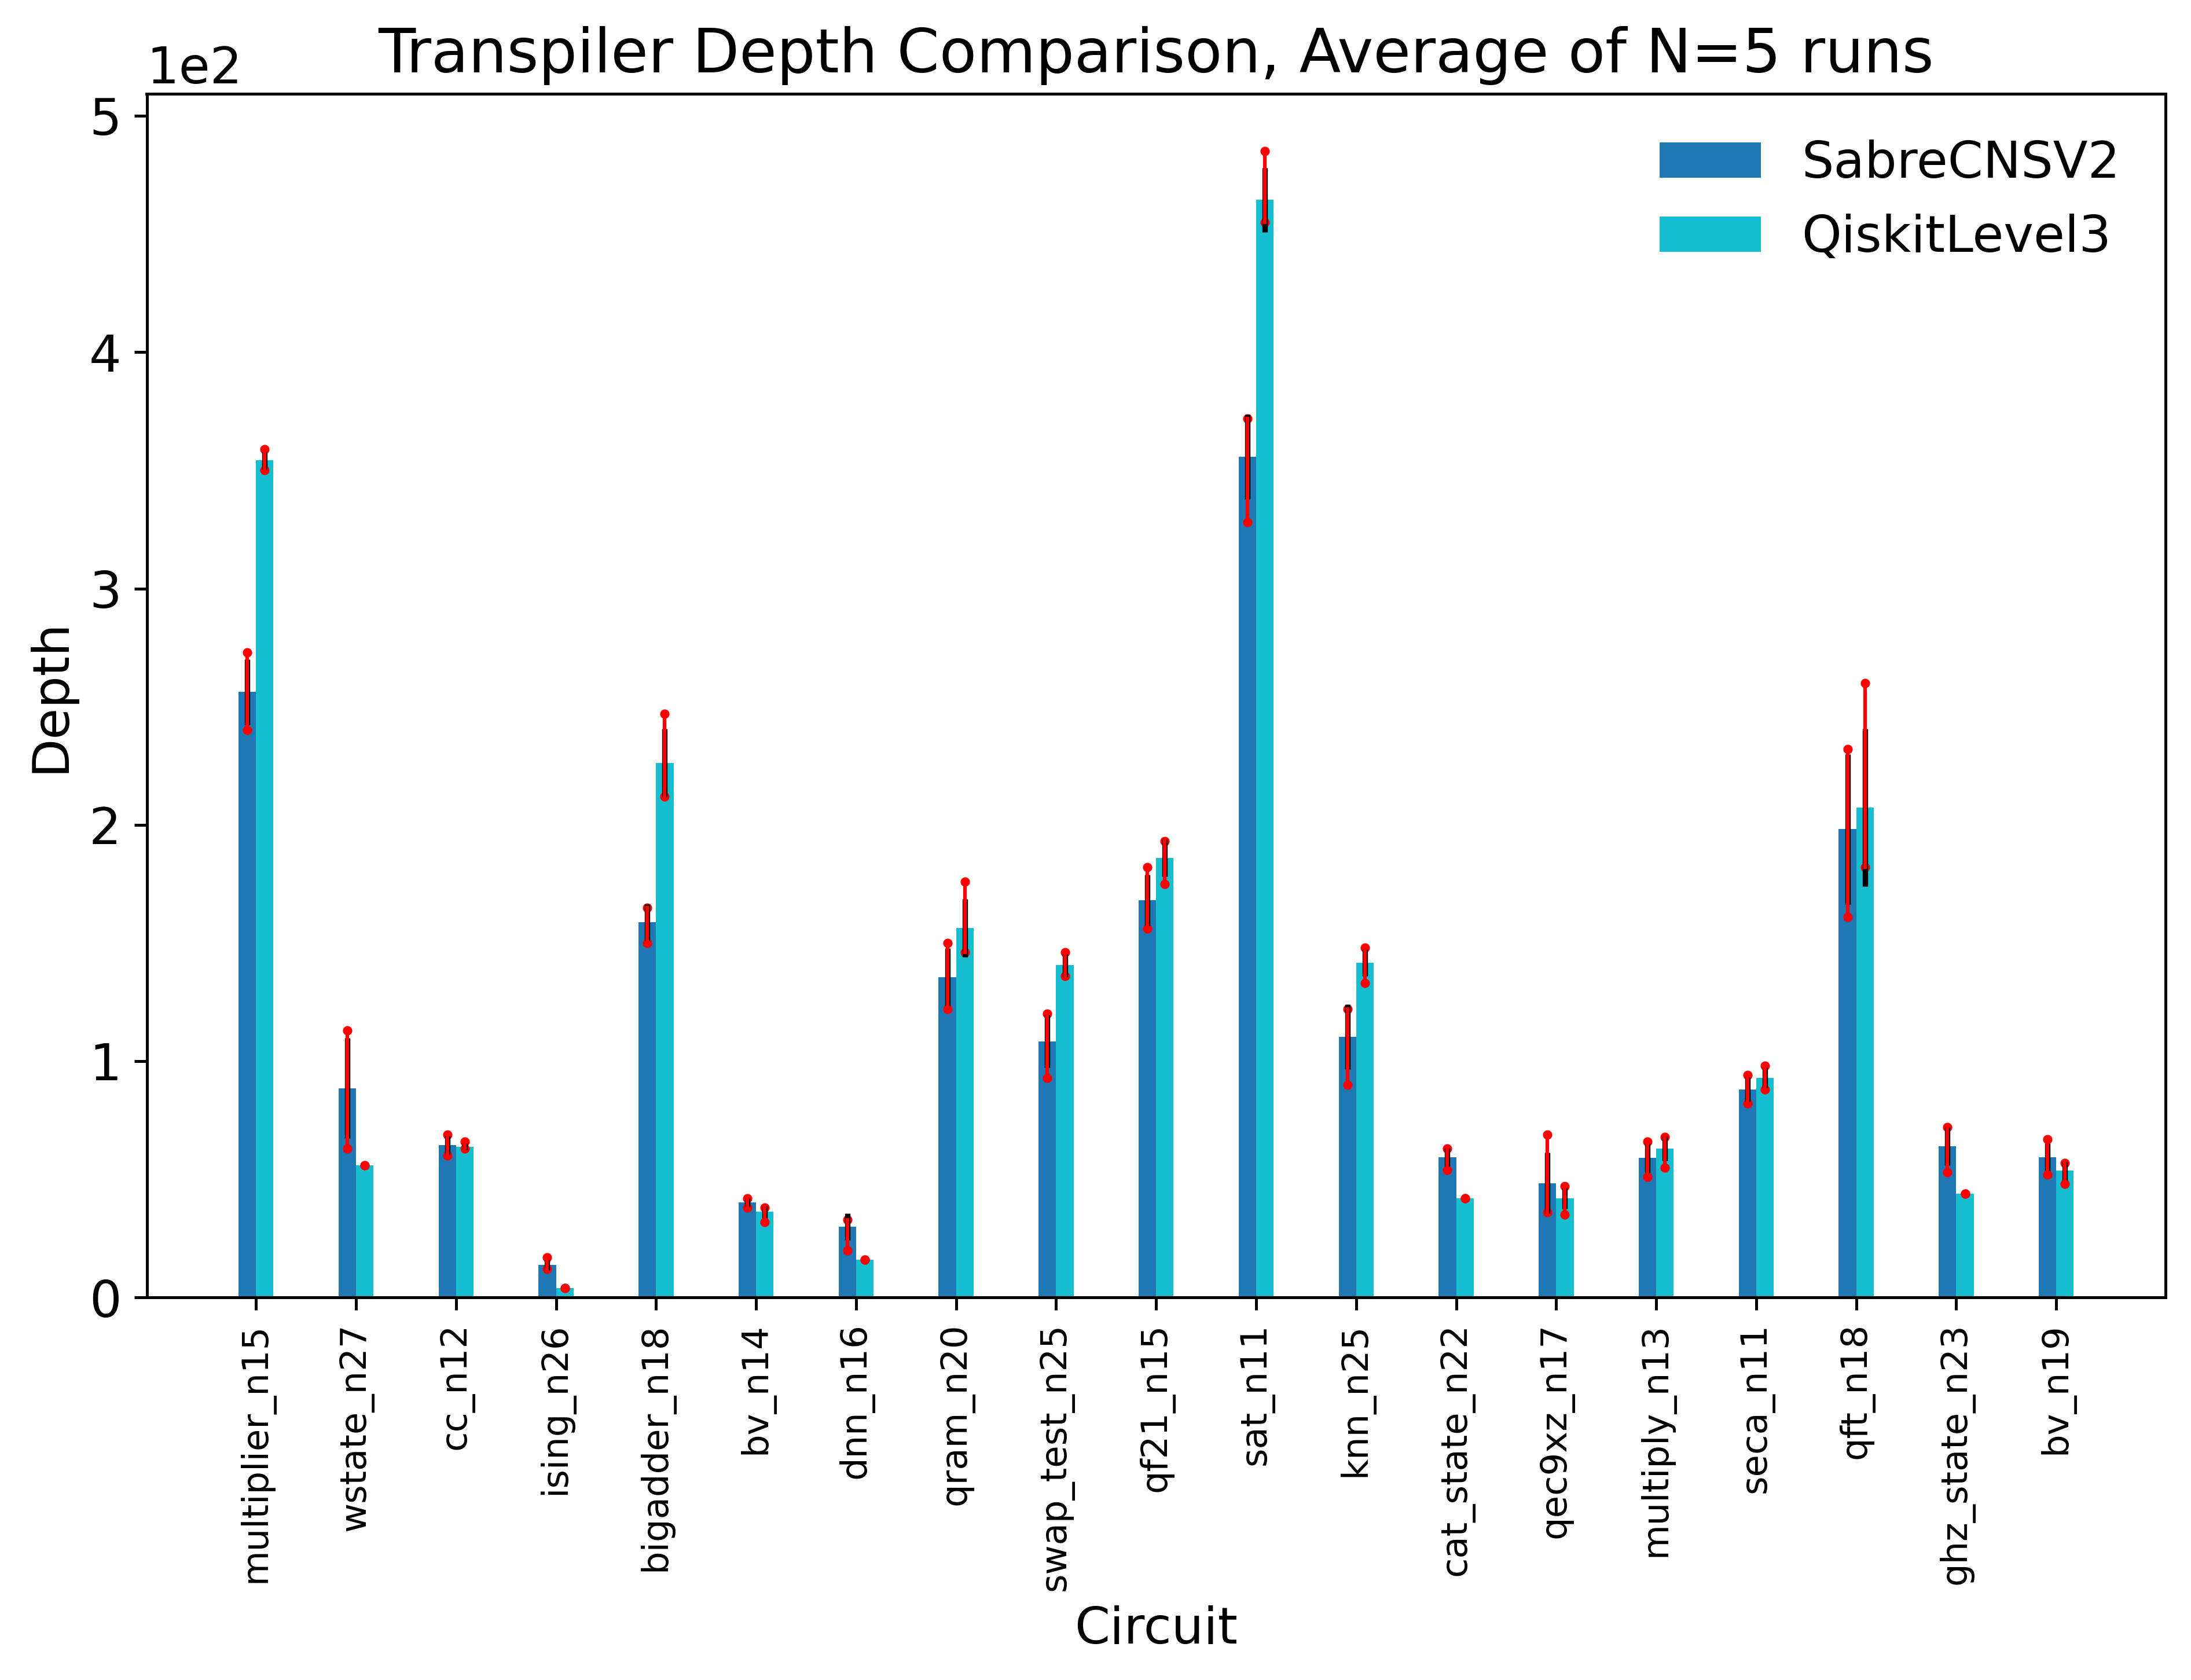

In [ ]:
benchmark.plot()

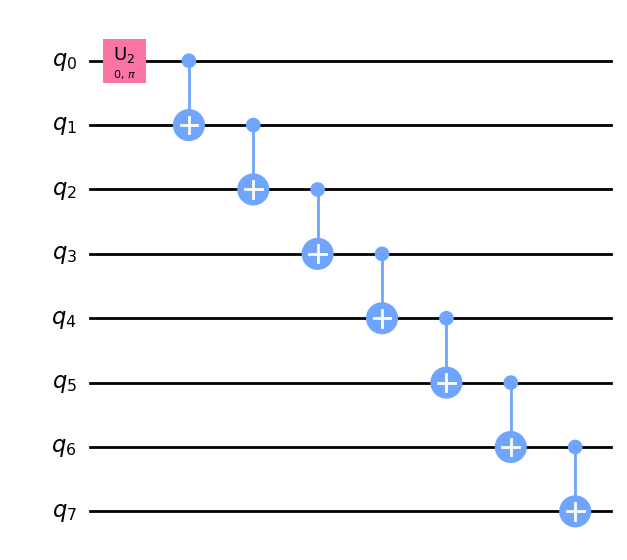

In [101]:
from qiskit.circuit.library import QFT

coupling_map = CouplingMap.from_grid(4, 4)
# qc = QFT(4)
qc = QuantumCircuit(8)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.cx(4, 5)
qc.cx(5, 6)
qc.cx(6, 7)
qc.decompose().draw(output="mpl")

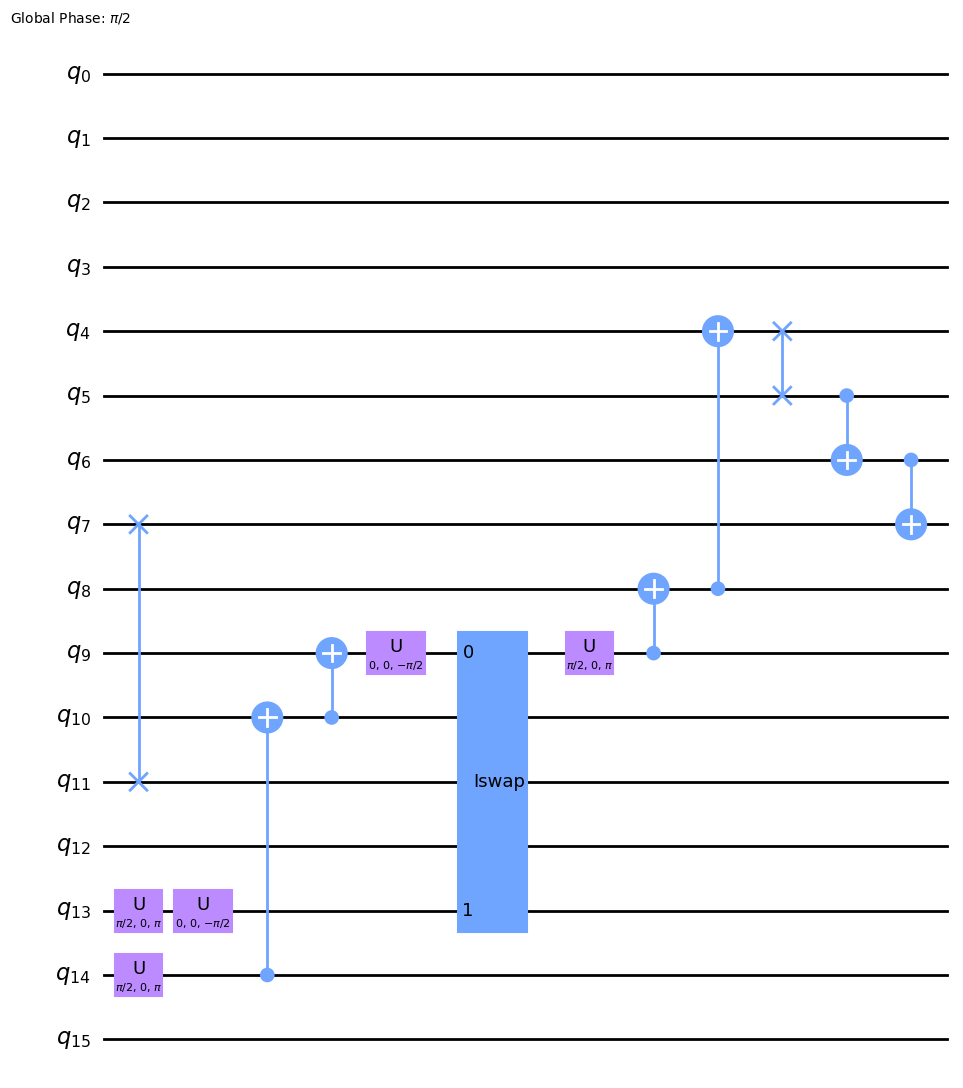

In [104]:
from virtual_swap.pass_managers import SabreCNSV2

runner = SabreCNSV2(coupling_map)
transp = runner.run(qc)
mid = runner.pm.property_set["circuit_progress"]
mid.draw(output="mpl")
# transp.draw(output="mpl")

In [96]:
runner.pm.property_set["layout"]

Layout({
3: Qubit(QuantumRegister(8, 'q'), 0),
6: Qubit(QuantumRegister(8, 'q'), 1),
7: Qubit(QuantumRegister(8, 'q'), 2),
8: Qubit(QuantumRegister(8, 'q'), 3),
5: Qubit(QuantumRegister(8, 'q'), 4),
2: Qubit(QuantumRegister(8, 'q'), 5),
1: Qubit(QuantumRegister(8, 'q'), 6),
4: Qubit(QuantumRegister(8, 'q'), 7),
0: Qubit(QuantumRegister(1, 'ancilla'), 0)
})

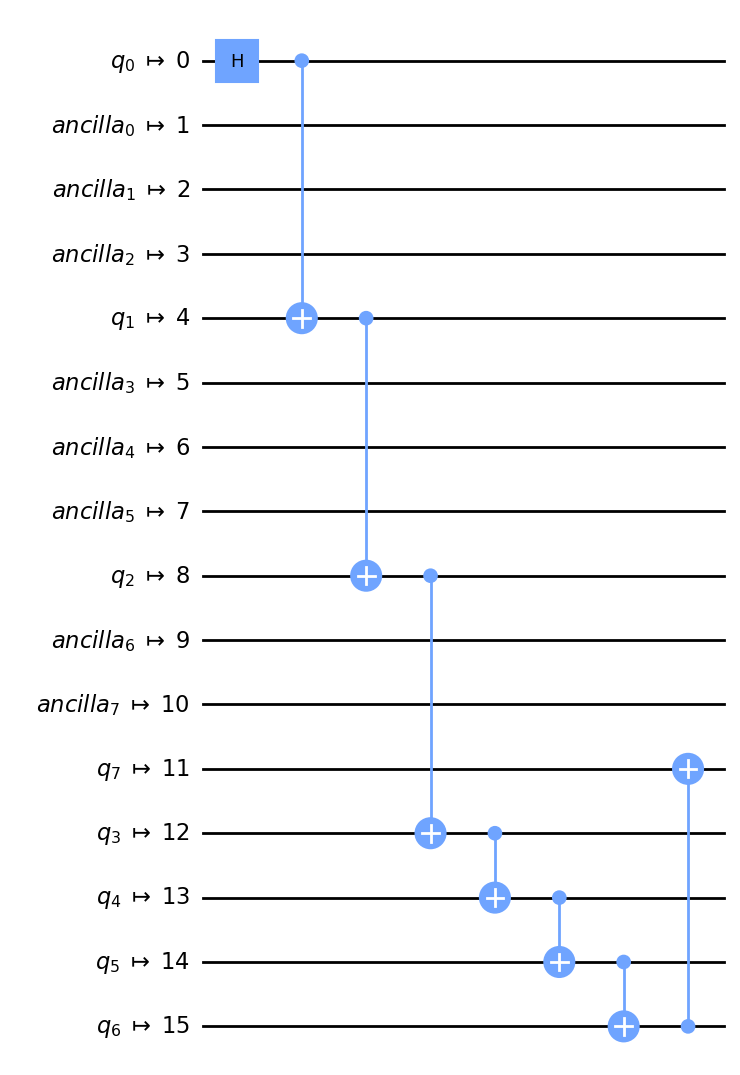

In [105]:
# set original qc to use
from qiskit import transpile

# qc2 = transpile(qc, initial_layout=runner.pm.property_set["layout"], coupling_map=coupling_map)
qc2 = transpile(qc, coupling_map=coupling_map, optimization_level=3)
qc2.draw("mpl")

In [98]:
# from qiskit.quantum_info import Operator
# Operator(mid).equiv(qc2)